In [69]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pickle
import torch
from dolfin import *
from mshr import *
import matplotlib.tri as tri
import matplotlib.cm as cm
import random
import torch
import time
import datetime
import subprocess
import os
import argparse
import gc
import sys
import pickle
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import diags
from pprint import pprint


import matplotlib.pyplot as plt
from network import *

In [70]:
mesh=np.load("/home/haltmayermarc/FEONet_Stokes/FEONet_time_dep_Stokes/data_ordered/P2x1_ne200_stokes_lower_BC_five_dt_0_1.npz", allow_pickle=True)
NUM_ELEMENT, NUM_PTS, p = mesh['ne'], mesh['ng'], mesh['p']
IDX_SOL = mesh['idx_sol']
A=mesh['A']
S=mesh['S']

In [71]:
gparams = {}
gparams['file'] = "1000N200"
BATCH_SIZE = 1000

class Dataset(Dataset):
    def __init__(self, gparams, mesh, kind='train'):
        self.pickle_file = gparams['file']
        with open(f'/home/haltmayermarc/FEONet_Stokes/FEONet_time_dep_Stokes/data_ordered/lower/five/0_1/{kind}/' + self.pickle_file + '.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.load_vector = mesh['load_vector']
        self.fenics_u1 = mesh[f'{kind}_fenics_u1']
        self.fenics_u2 = mesh[f'{kind}_fenics_u2']
        self.fenics_p = mesh[f'{kind}_fenics_p']
    def __getitem__(self, idx):
        coeffs_u    = torch.as_tensor(self.data[idx,0], dtype=torch.float32)
        init_value_x = torch.as_tensor(self.data[idx,1], dtype=torch.float32).unsqueeze(0)
        init_value_y = torch.as_tensor(self.data[idx,2], dtype=torch.float32).unsqueeze(0)
        coeffs_init  = torch.as_tensor(self.data[idx,3], dtype=torch.float32)
        load_vec_f = torch.as_tensor(self.load_vector, dtype=torch.float32)
        fenics_u1  = torch.as_tensor(self.fenics_u1[idx], dtype=torch.float32)
        fenics_u2  = torch.as_tensor(self.fenics_u2[idx], dtype=torch.float32)
        fenics_p   = torch.as_tensor(self.fenics_p[idx], dtype=torch.float32)

        return {
            'coeffs_u': coeffs_u,
            'init_value_x': init_value_x,
            'init_value_y': init_value_y,
            'coeffs_init': coeffs_init,
            'load_vec_f': load_vec_f,
            'fenics_u1': fenics_u1,
            'fenics_u2': fenics_u2,
            'fenics_p': fenics_p,
            }


    def __len__(self):
        return len(self.data)

lg_dataset = Dataset(gparams, mesh, kind='train')
trainloader = DataLoader(lg_dataset, batch_size=BATCH_SIZE, shuffle=True)
lg_dataset = Dataset(gparams, mesh, kind='validate')
validateloader = DataLoader(lg_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [72]:
model_FEONet = VectorToSequenceRNN(input_dim=1003,
                         hidden_dim = 512,
                         output_dim = 1003,
                         rnn_type = "lstm",
                         num_layers = 5)

In [73]:
A = torch.tensor(mesh['A']).to_sparse().float()
S = torch.tensor(mesh['S']).to_sparse().float()

In [74]:
for validate_data in validateloader:
    coeffs_u = validate_data['coeffs_u']
    init_value_x = validate_data['init_value_x']
    init_value_y = validate_data['init_value_y']
    coeffs_init = validate_data['coeffs_init']
    load_vec_f  = validate_data['load_vec_f']
    fenics_u1 = validate_data['fenics_u1']
    fenics_u2 = validate_data['fenics_u2']
    fenics_p = validate_data['fenics_p']

In [75]:
state_dict=torch.load("/home/haltmayermarc/FEONet_Stokes/FEONet_time_dep_Stokes/model/lower/0_1/RNN/model.pt", map_location=torch.device('cpu'), weights_only=False)
#learned_params = torch.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole/model_ordered/model.pth", weights_only=False)

In [76]:
model_FEONet.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [77]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, axis=-1)/torch.sum((true)**2, axis=-1))**0.5

In [78]:
def assemble_u_init(init_x, init_y, idx_sol, num_pts, device):
    if init_x.dim() == 3:
        init_x = init_x.squeeze(1)
    if init_y.dim() == 3:
        init_y = init_y.squeeze(1)

    B = init_x.size(0)
    u0 = torch.zeros(B, num_pts, device=device)

    idx_u1, idx_u2, _ = IDX_SOL
    u0[:, torch.as_tensor(idx_u1, device=device, dtype=torch.long)] = init_x
    u0[:, torch.as_tensor(idx_u2, device=device, dtype=torch.long)] = init_y
    return u0

u_init = assemble_u_init(init_value_x, init_value_y, IDX_SOL, NUM_PTS, "cpu")

In [79]:
pred_coeff_u = model_FEONet(u_init, seq_len=10).detach().numpy()

In [80]:
p[torch.tensor(IDX_SOL[0])][:,0].shape

(441,)

In [81]:
plot_idx=np.random.randint(len(validateloader.dataset))

In [82]:
pred_coeff_u[plot_idx,1,IDX_SOL[0]].shape

(441,)

/tmp/ipykernel_332746/2792364150.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')


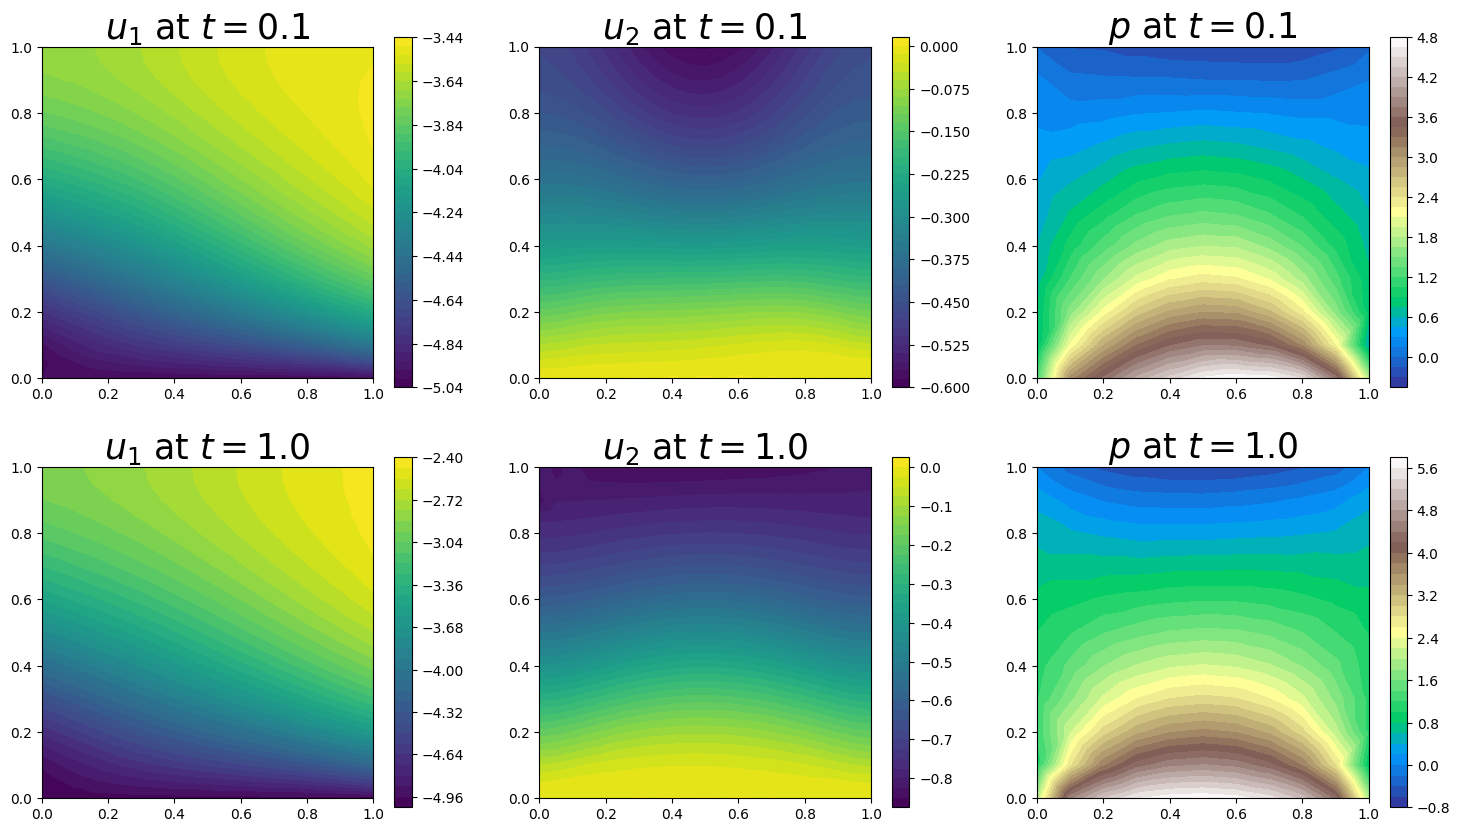

In [83]:
T=[0,1]
dt=0.1
grid_t=np.arange(T[0],T[1]+dt,dt)
fig=plt.figure(figsize=(20,10))
cmap = cm.get_cmap(name='terrain')

# t=first step
idx=1
x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,1)
ax.set_title(r'$u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[0]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)



x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,2)
ax.set_title(r'$u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[1]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)




x=p[torch.tensor(IDX_SOL[2])][:,0]
y=p[torch.tensor(IDX_SOL[2])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,3)
ax.set_title(r'$p$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[2]], cmap="terrain", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)






# t=Last step
idx=-1
x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,4)
ax.set_title(r'$u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[0]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)



x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,5)
ax.set_title(r'$u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[1]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)




x=p[torch.tensor(IDX_SOL[2])][:,0]
y=p[torch.tensor(IDX_SOL[2])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,6)
ax.set_title(r'$p$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx-1,IDX_SOL[2]], cmap="terrain", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
fig.colorbar(im)

In [84]:
coeffs_u_cut = coeffs_u[:, 1:, :]
linalg_u1_cut = coeffs_u_cut[:, :, IDX_SOL[0]]
linalg_u2_cut = coeffs_u_cut[:, :, IDX_SOL[1]]
linalg_p_cut = coeffs_u_cut[:, :, IDX_SOL[2]]

In [85]:
linalg_u1_cut.shape

torch.Size([1000, 10, 441])

In [86]:
pred_coeff_u.shape

(1000, 10, 1003)

Linalg

/tmp/ipykernel_332746/1739470516.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')


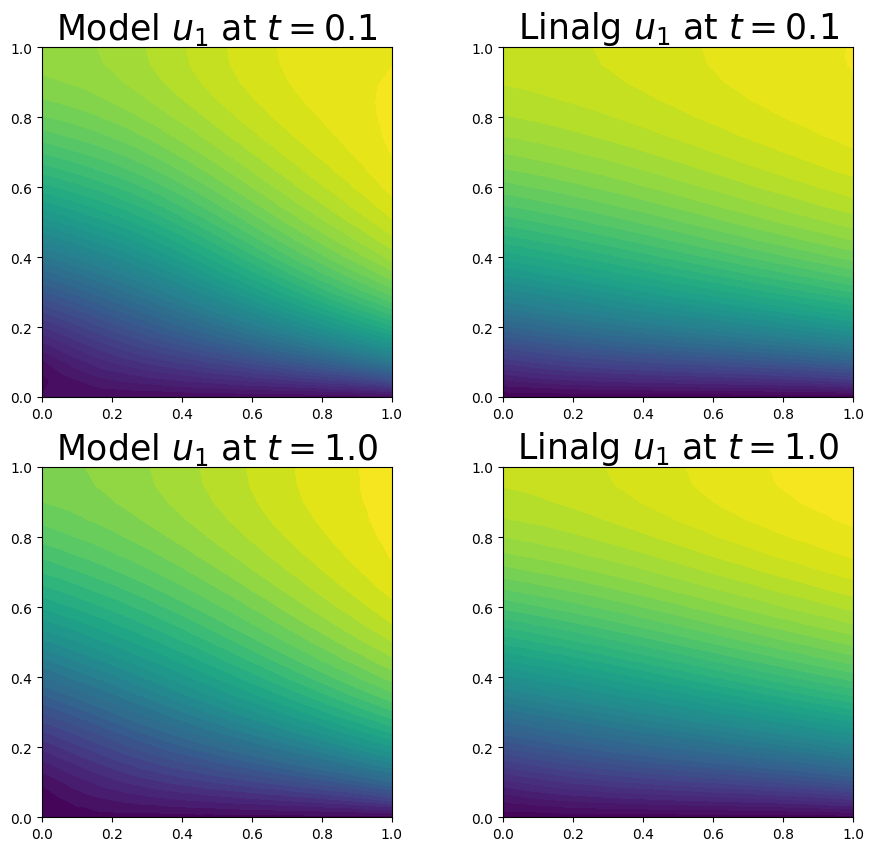

In [90]:
fig=plt.figure(figsize=(12,10))
cmap = cm.get_cmap(name='terrain')

# t=first step
idx=1
x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,1)
ax.set_title(r'Model $u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[0]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,2)
ax.set_title(r'Linalg $u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, linalg_u1_cut[plot_idx,idx,:], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


# t=last
idx=-1
x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,3)
ax.set_title(r'Model $u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[0]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


x=p[torch.tensor(IDX_SOL[0])][:,0]
y=p[torch.tensor(IDX_SOL[0])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,4)
ax.set_title(r'Linalg $u_1$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, linalg_u1_cut[plot_idx,idx,:], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)

/tmp/ipykernel_332746/2694652723.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(name='terrain')


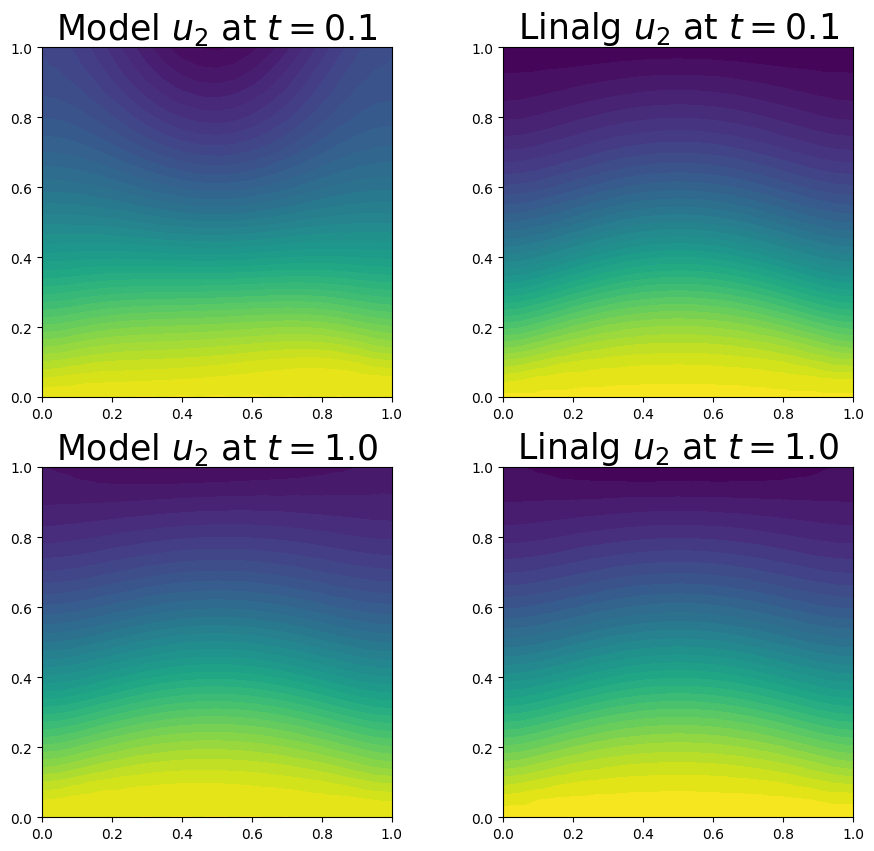

In [91]:
fig=plt.figure(figsize=(12,10))
cmap = cm.get_cmap(name='terrain')

# t=first step
idx=1
x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,1)
ax.set_title(r'Model $u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[1]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,2)
ax.set_title(r'Linalg $u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, linalg_u2_cut[plot_idx,idx,:], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


# t=last
idx=-1
x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,3)
ax.set_title(r'Model $u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, pred_coeff_u[plot_idx,idx,IDX_SOL[1]], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)


x=p[torch.tensor(IDX_SOL[1])][:,0]
y=p[torch.tensor(IDX_SOL[1])][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,2,4)
ax.set_title(r'Linalg $u_2$ at $t={}$'.format(grid_t[idx]),fontsize=25)
im=ax.tricontourf(triang, linalg_u2_cut[plot_idx,idx,:], cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
#fig.colorbar(im)